In [3]:
import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects
from skimage import data, morphology

In [4]:
im1 = cv2.imread('task_3_image_1.png', 0)
im2 = cv2.imread('task_3_image_2.png', 0)

### Cropping

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Threshold for detecting the edge
threshold = 70

# Horizontal and vertical lines to analyze
horizontal_line = im2[1503, 0:4112]  # Pixel values along the horizontal line
vertical_line = im2[0:3006, 2056]    # Pixel values along the vertical line

# Function to find edges by looping through the line
def find_edges(line, threshold):

    left_edge, right_edge = None, None
    n = len(line)
    
    # Loop from the left to find the first transition
    for i in range(1, n):
        if line[i-1] < threshold <= line[i] or line[i-1] >= threshold > line[i]:
            left_edge = i
            break
    
    # Loop from the right to find the last transition
    for i in range(n-1, 0, -1):
        if line[i] < threshold <= line[i-1] or line[i] >= threshold > line[i-1]:
            right_edge = i
            break
    
    return left_edge, right_edge

# Function to return a slice of found edges
def format(image):
    horizontal_line = image[1503, 0:4112]  
    vertical_line = image[0:3006, 2056]  
    left_x, right_x = find_edges(horizontal_line, threshold)
    top_y, bottom_y = find_edges(vertical_line, threshold)
    # Ensure the output region is a square
    side_length = max(right_x - left_x, bottom_y - top_y)
    right_x = left_x + side_length
    bottom_y = top_y + side_length
    return slice(top_y, bottom_y), slice(left_x, right_x)


# Analyze the horizontal line (x-coordinates)
left_x, right_x = find_edges(horizontal_line, threshold)

# Analyze the vertical line (y-coordinates)
top_y, bottom_y = find_edges(vertical_line, threshold)



### Cropping image 1:

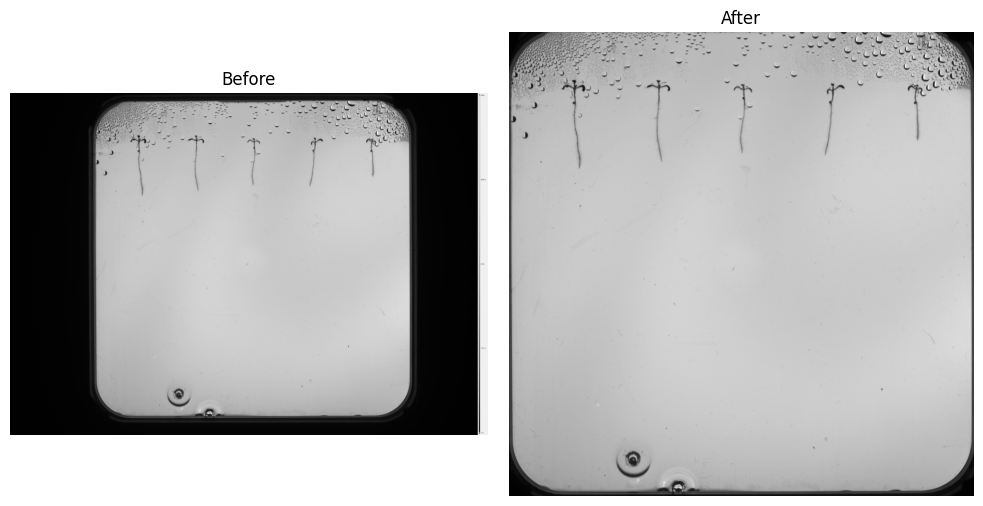

(2788, 2788)


In [6]:
cropped_im1 = im1[format(im1)]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
# Display the first image
axes[0].imshow(im1, cmap = 'gray')
axes[0].axis('off')  # Turn off axes
axes[0].set_title("Before")

# Display the second image
axes[1].imshow(cropped_im1, cmap = 'gray')
axes[1].axis('off')  # Turn off axes
axes[1].set_title("After")

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()

print(cropped_im1.shape)

### Cropping image 2:

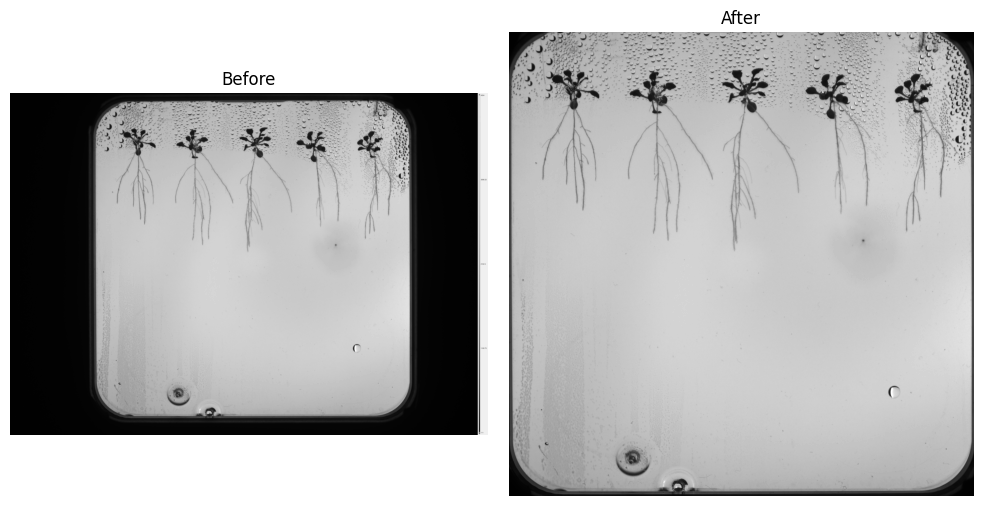

(2789, 2789)


In [155]:
cropped_im2 = im2[format(im2)]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
# Display the first image
axes[0].imshow(im2, cmap = 'gray')
axes[0].axis('off')  # Turn off axes
axes[0].set_title("Before")

# Display the second image
axes[1].imshow(cropped_im2, cmap = 'gray')
axes[1].axis('off')  # Turn off axes
axes[1].set_title("After")

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()

print(cropped_im2.shape)

### Root segmentation:

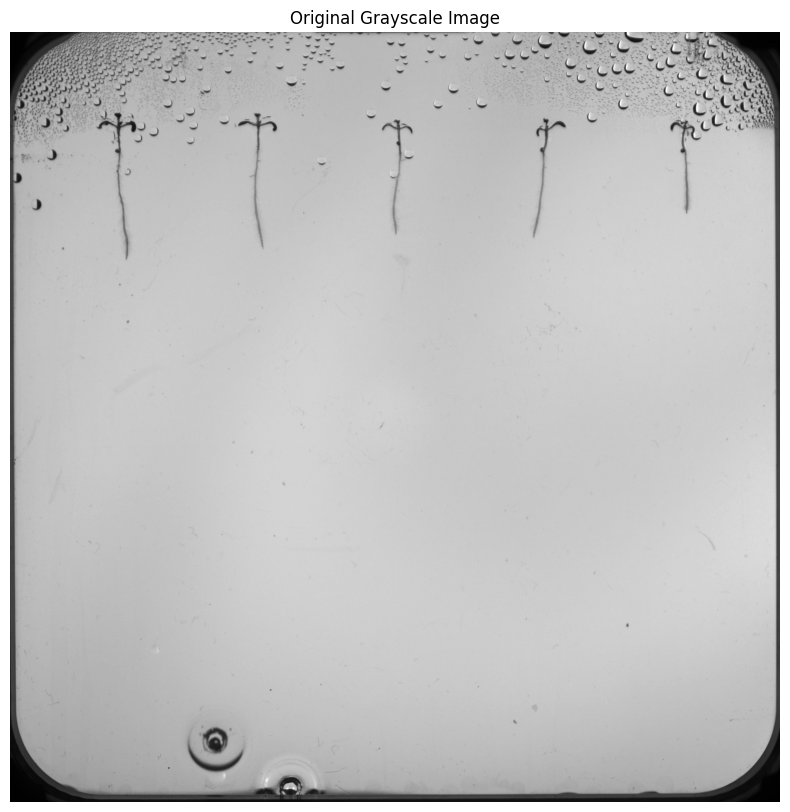

In [156]:
# Block 1: Load and visualize the grayscale image
import cv2
import matplotlib.pyplot as plt


image = cropped_im1 

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')
plt.show()


### Thresholding

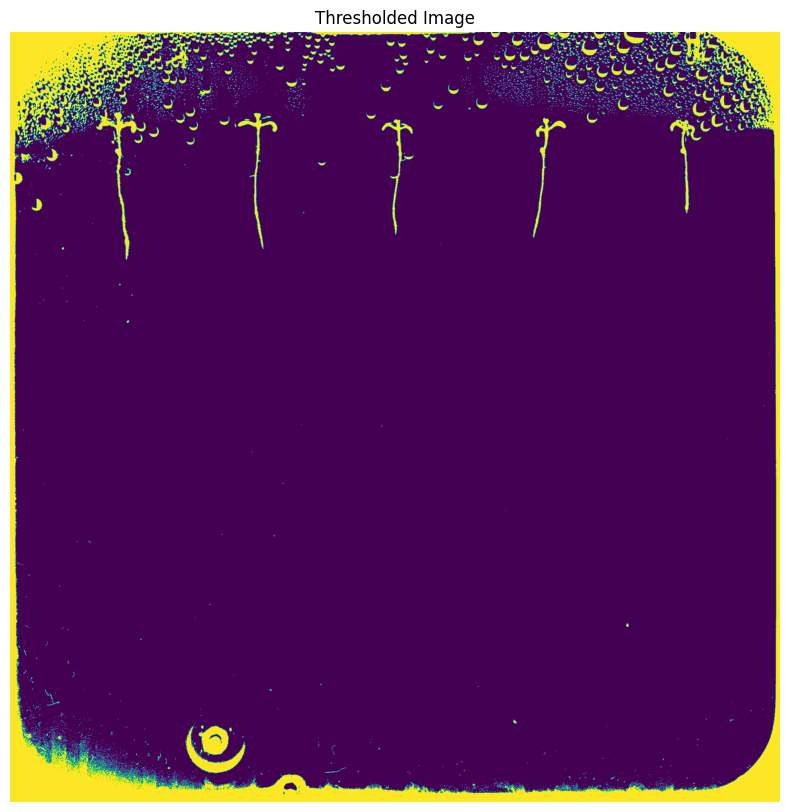

In [157]:
# Block 2: Thresholding
_, thresh = cv2.threshold(image, 165, 255, cv2.THRESH_BINARY_INV)  
blurred = cv2.GaussianBlur(thresh, (17, 17), 0)

plt.figure(figsize=(10, 10))
plt.imshow(thresh, cmap='viridis')
plt.title("Thresholded Image")
plt.axis('off')
plt.show()


### Retrieving the labels from the Thresholded binary image:

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


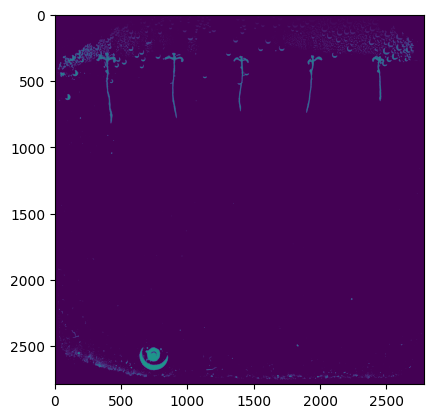

In [158]:
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)
plt.imshow(labels)
print(labels)

### Function for plant segmentation:

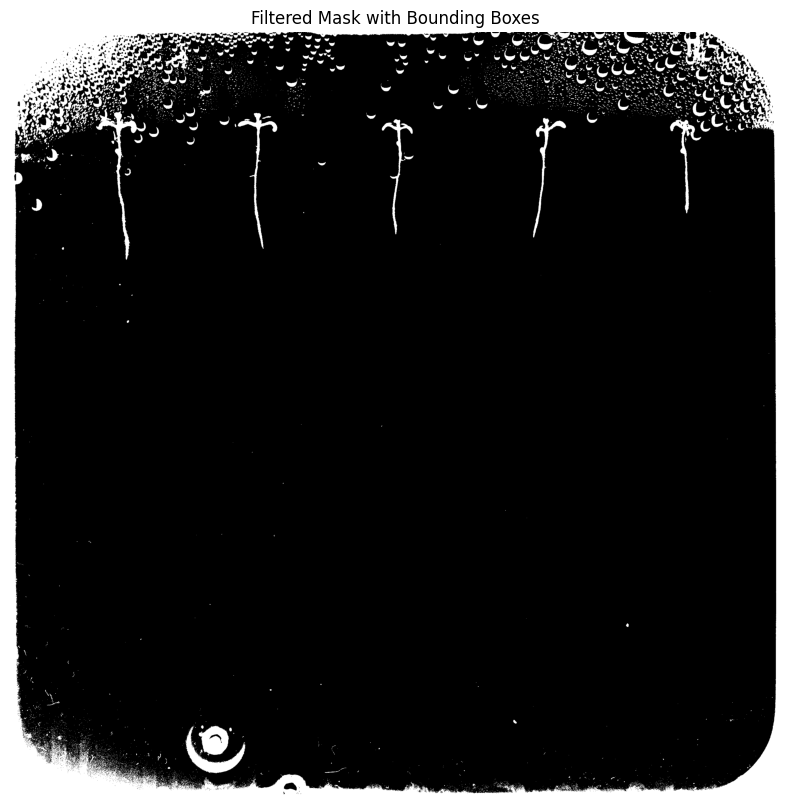

In [159]:
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import cv2
import numpy as np

def segment_plants_with_bboxes(binary_image, min_area=500, aspect_ratio_range=(0.1, 5.0)):
    """
    Segments plants using bounding boxes.

    Parameters:
        binary_image (np.ndarray): Binary input image (True/False or 0/1).
        min_area (int): Minimum area of a bounding box to keep.
        aspect_ratio_range (tuple): Range of acceptable aspect ratios (width/height).

    Returns:
        list: List of bounding boxes (x_min, y_min, x_max, y_max).
        np.ndarray: Mask with only the selected bounding boxes retained.
    """
    # Label connected components
    labeled_image = label(binary_image)
    
    # List to store bounding boxes
    bounding_boxes = []
    
    # Filter regions based on size and aspect ratio
    for region in regionprops(labeled_image):
        if region.area >= min_area:  # Filter by area
            # Get bounding box coordinates
            minr, minc, maxr, maxc = region.bbox
            width, height = maxc - minc, maxr - minr
            aspect_ratio = width / height
            
            # Filter by aspect ratio
            if aspect_ratio_range[0] <= aspect_ratio <= aspect_ratio_range[1]:
                bounding_boxes.append((minc, minr, maxc, maxr))
    
    # Create a blank mask to show selected regions
    filtered_mask = np.zeros_like(binary_image, dtype=bool)
    for bbox in bounding_boxes:
        minc, minr, maxc, maxr = bbox
        filtered_mask[minr:maxr, minc:maxc] = binary_image[minr:maxr, minc:maxc]
    
    return bounding_boxes, filtered_mask


# Apply the bounding box segmentation
bboxes, filtered_mask = segment_plants_with_bboxes(labels, min_area=500)

# Visualize the filtered mask
plt.figure(figsize=(10, 10))
plt.imshow(filtered_mask, cmap="gray")
plt.title("Filtered Mask with Bounding Boxes")
plt.axis("off")
plt.show()


### Function for drawing the bounding boxes:

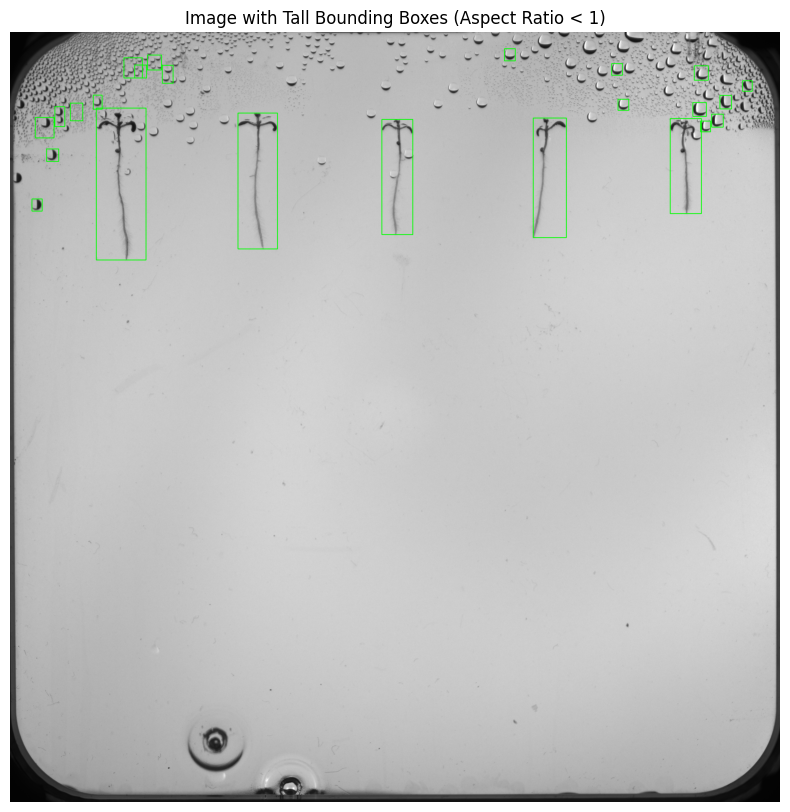

In [160]:
def draw_bounding_boxes(image, bboxes):
    """
    Draws tall bounding boxes (aspect ratio < 1) on the image.

    Parameters:
        image (np.ndarray): Original grayscale or color image.
        bboxes (list): List of bounding boxes (x_min, y_min, x_max, y_max).

    Returns:
        np.ndarray: Image with tall bounding boxes drawn.
    """
    # Convert image to BGR if grayscale
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Filter and draw each tall bounding box
    for bbox in bboxes:
        minc, minr, maxc, maxr = bbox
        width = maxc - minc
        height = maxr - minr
        aspect_ratio = width / height
        
        # Only draw tall bounding boxes with an aspect ratio < 1
        if aspect_ratio < 1:
            cv2.rectangle(image, (minc, minr), (maxc, maxr), (0, 255, 0), 2)
    
    return image

# Draw tall bounding boxes on the original image
image_with_bboxes = draw_bounding_boxes(image.copy(), bboxes)

# Visualize the image with tall bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_bboxes, cv2.COLOR_BGR2RGB))
plt.title("Image with Tall Bounding Boxes (Aspect Ratio < 1)")
plt.axis("off")
plt.show()


### Function for extracting the top 5 biggest bounding boxes, with a tall aspect ratio (plants):

C:\Users\batkm\AppData\Local\Temp\ipykernel_972\2585356959.py:57: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 2111 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  filtered_labels[labels == i] = i  # Add to the filtered mask
C:\Users\batkm\AppData\Local\Temp\ipykernel_972\2585356959.py:57: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 2226 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  filtered_labels[labels == i] = i  # Add to the filtered mask
C:\Users\batkm\AppData\Local\Temp\ipykernel_972\2585356959.py:57: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The 

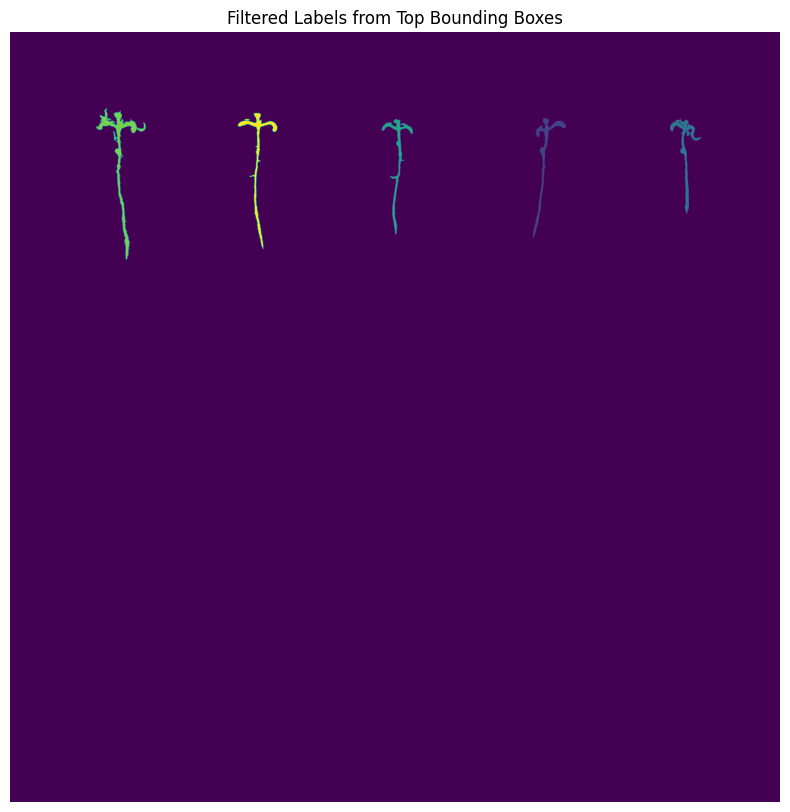

Top Stats:
[[  312   275   180   550 10297]
 [  825   293   143   492  6689]
 [ 1894   311   120   433  5772]
 [ 1346   316   112   417  5267]
 [ 2390   313   113   344  5583]]
Top Centroids:
[[ 398.1680101   454.33611732]
 [ 897.11197488  459.1825385 ]
 [1936.33073458  453.14275814]
 [1401.80729068  458.77653313]
 [2444.12287301  428.40211356]]


In [161]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_top_bounding_boxes_stats_with_drawing(image, thresh, bboxes, top_n=5):
    """
    Filters stats from `cv2.connectedComponentsWithStats` based on top bounding boxes
    and ensures only tall bounding boxes (aspect ratio < 1) are used.

    Parameters:
        image (np.ndarray): Original grayscale or color image.
        thresh (np.ndarray): Binary thresholded image.
        bboxes (list): List of bounding boxes (x_min, y_min, x_max, y_max).
        top_n (int): Number of largest bounding boxes to keep.

    Returns:
        tuple: (top_labels, top_stats, top_centroids) for the top bounding boxes.
    """
    # Perform connected components analysis
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)

    # Extract areas for all bounding boxes in stats
    areas = stats[:, cv2.CC_STAT_AREA]

    # Filter only the bounding boxes with tall aspect ratio (< 1)
    filtered_bboxes = []
    for bbox in bboxes:
        minc, minr, maxc, maxr = bbox
        width = maxc - minc
        height = maxr - minr
        aspect_ratio = width / height
        
        if aspect_ratio < 1:  # Only include tall bounding boxes
            filtered_bboxes.append(bbox)

    # If fewer than `top_n` bounding boxes remain, adjust `top_n`
    top_n = min(len(filtered_bboxes), top_n)

    # Sort bounding boxes by area (descending order)
    bbox_areas = [(bbox, (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])) for bbox in filtered_bboxes]
    bbox_areas = sorted(bbox_areas, key=lambda x: x[1], reverse=True)

    # Select the top N bounding boxes
    top_bboxes = [item[0] for item in bbox_areas[:top_n]]

    # Generate a filtered labels mask and stats
    filtered_labels = np.zeros_like(labels, dtype=np.uint8)
    top_stats = []
    top_centroids = []

    for bbox in top_bboxes:
        minc, minr, maxc, maxr = bbox
        # Extract the corresponding connected component label
        for i in range(1, retval):  # Skip background (label 0)
            x, y, w, h, area = stats[i]
            if (x == minc and y == minr and (x + w) == maxc and (y + h) == maxr):
                filtered_labels[labels == i] = i  # Add to the filtered mask
                top_stats.append(stats[i])
                top_centroids.append(centroids[i])
                break

    return filtered_labels, np.array(top_stats), np.array(top_centroids)

# Visualize the resulting labels
top_labels, top_stats, top_centroids = get_top_bounding_boxes_stats_with_drawing(
    image.copy(), thresh, bboxes, top_n=5
)
for new_label, old_label in enumerate(np.unique(top_labels)[1:], start=1):
    top_labels[top_labels == old_label] = new_label

# Visualize the filtered labels
plt.figure(figsize=(10, 10))
plt.imshow(top_labels)
plt.title("Filtered Labels from Top Bounding Boxes")
plt.axis("off")
plt.show()

# Print stats and centroids for debugging
print("Top Stats:")
print(top_stats)
print("Top Centroids:")
print(top_centroids)


### Repeated for image 2:

C:\Users\batkm\AppData\Local\Temp\ipykernel_972\2585356959.py:57: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 926 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  filtered_labels[labels == i] = i  # Add to the filtered mask
C:\Users\batkm\AppData\Local\Temp\ipykernel_972\2585356959.py:57: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 930 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  filtered_labels[labels == i] = i  # Add to the filtered mask
C:\Users\batkm\AppData\Local\Temp\ipykernel_972\2585356959.py:57: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The co

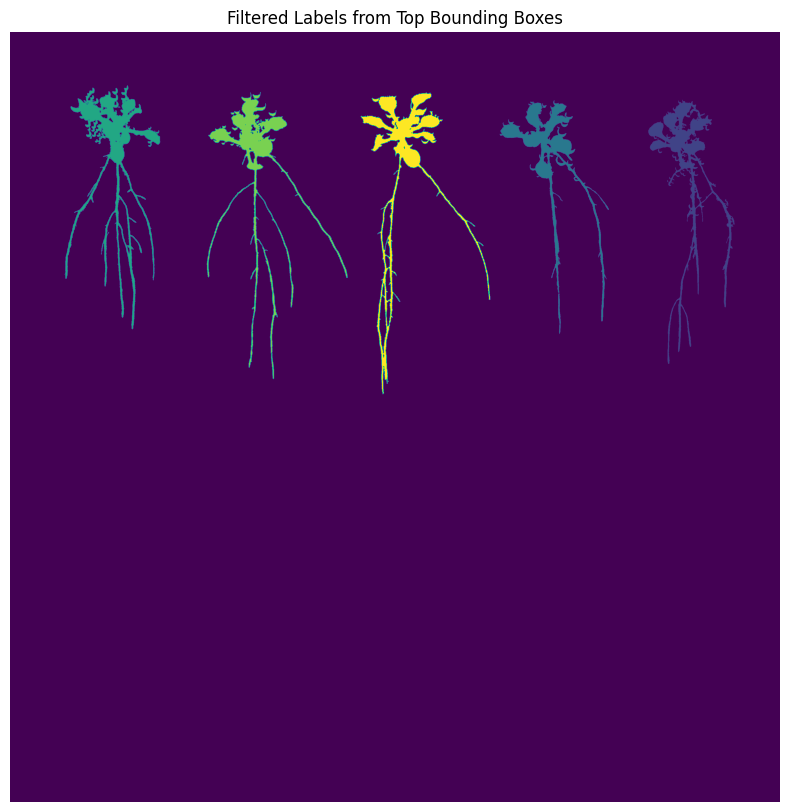

In [164]:
image = cropped_im2 

# Block 2: Thresholding
_, thresh = cv2.threshold(image, 165, 255, cv2.THRESH_BINARY_INV)  
blurred = cv2.GaussianBlur(thresh, (17, 17), 0)

retval, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)

bboxes, filtered_mask = segment_plants_with_bboxes(labels, min_area=500)
image_with_bboxes = draw_bounding_boxes(image.copy(), bboxes)
# Visualize the resulting labels
top_labels, top_stats, top_centroids = get_top_bounding_boxes_stats_with_drawing(
    image.copy(), thresh, bboxes, top_n=5
)
for new_label, old_label in enumerate(np.unique(top_labels)[1:], start=1):
    top_labels[top_labels == old_label] = new_label

# Visualize the filtered labels
plt.figure(figsize=(10, 10))
plt.imshow(top_labels)
plt.title("Filtered Labels from Top Bounding Boxes")
plt.axis("off")
plt.show()